In [1]:
import openai
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pickle
from tqdm import tqdm, trange
from IPython.display import display, Markdown, HTML
import re
from matplotlib.animation import FuncAnimation

from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, AnswerRelevancyMetric, FaithfulnessMetric, HallucinationMetric
from deepeval.evaluate import evaluate, DisplayConfig

In [2]:
# --- Funkcje ---
def get_response(prompt, temperature=0.7):
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=300
    )
    return response.choices[0].message.content.strip()

def normalize_markdown(text):
    # usuń nagłówki i znaczniki
    text = re.sub(r"`{1,3}[^`]+`{1,3}", "", text)  # kod inline
    text = re.sub(r"#+\\s*", "", text)            # nagłówki
    text = re.sub(r"\\*\\*?|__?", "", text)        # pogrubienie/kursywa
    text = re.sub(r"!?\[.*?\]\(.*?\)", "", text)   # linki i obrazki
    text = re.sub(r"[\\*\\-\\_]{2,}", " ", text)   # linie poziome
    return text.strip()

def get_similarity(text1, text2):
    text1 = normalize_markdown(text1)
    text2 = normalize_markdown(text2)
    emb1 = embedding_model.encode([text1])[0]
    emb2 = embedding_model.encode([text2])[0]
    return cosine_similarity([emb1], [emb2])[0][0]

In [3]:
# --- Modele embeddingowe ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [4]:
# --- Parametry ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_KEY
N_SIMULATIONS = 100
MODEL = 'gpt-4.1-nano'
TEMPERATURE = 0.2
PROMPT = "Wyjaśnij, czym jest fotosynteza, w sposób zrozumiały dla ucznia szkoły podstawowej."
REFERENCE = "Fotosynteza to proces, w którym rośliny zamieniają światło słoneczne, wodę i dwutlenek węgla w tlen i cukier."

CONTEXT = [(
    "Fotosynteza to proces, w którym zielone rośliny, algi i niektóre bakterie przekształcają energię świetlną "
    "w energię chemiczną. Zachodzi ona głównie w chloroplastach, zawierających chlorofil. "
    "W trakcie fotosyntezy rośliny pochłaniają dwutlenek węgla (CO2) z powietrza i wodę (H2O) z gleby. "
    "Pod wpływem światła słonecznego przekształcają te substancje w glukozę (cukier) i tlen (O2). "
    "Fotosynteza jest kluczowa dla życia na Ziemi, ponieważ produkuje tlen i stanowi podstawę łańcucha pokarmowego."
)]
RETRIEVAL_CONTEXT=[(
            "Chlorofil to zielony barwnik znajdujący się w chloroplastach, który umożliwia absorpcję światła potrzebnego do fotosyntezy."
            "Dwutlenek węgla jest pobierany z atmosfery przez aparaty szparkowe na liściach roślin."
            "Woda dostarczana jest do liści przez system korzeniowy i naczynia przewodzące."
)]

In [5]:
# --- Metryki LLM ---
answer_relevancy_metric = AnswerRelevancyMetric(threshold=TEMPERATURE, model=MODEL,include_reason=False)
faithfulness_metric = FaithfulnessMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
hallucination_metric = HallucinationMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
correctness_metric = GEval(
    name="Correctness",
    model=MODEL,
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should also heavily penalize omission of detail",
        "Vague language, or contradicting OPINIONS, are OK"
    ],
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

In [8]:
# --- Symulacja Monte Carlo (MC) ---
outputs = []
for i in tqdm(range(N_SIMULATIONS)):
    output = get_response(PROMPT, TEMPERATURE)
    outputs.append(output)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


In [ ]:
with open('./data/outputs_classical_t02.pkl', 'wb') as fp:
    pickle.dump(outputs, fp)

In [6]:
with open ('./data/outputs_classical_t02.pkl', 'rb') as fp:
    outputs = pickle.load(fp)
print(len(outputs))

100


In [7]:
test_cases = []
for i in range(len(outputs)):
    similarity = get_similarity(outputs[i], REFERENCE)
    length = len(outputs[i].split())

    test_case = LLMTestCase(
        input=PROMPT,
        actual_output=outputs[i],
        expected_output=REFERENCE,
        retrieval_context=RETRIEVAL_CONTEXT,
        context=CONTEXT
    )

    test_case.metadata = {
        "simulation": i + 1,
        "output": outputs[i],
        "similarity": similarity,
        "length": length
    }
    
    test_cases.append(test_case)

In [ ]:
USE_DEEPEVAL = True
results = []
for i in range(20):
    from_i = i*5
    to_i = (i+1)*5
    print(from_i, to_i)
    ts=test_cases[from_i:to_i]
    eval_result = None
    if USE_DEEPEVAL:
        eval_result = evaluate(
            test_cases=ts,
            metrics=[answer_relevancy_metric, faithfulness_metric, hallucination_metric, correctness_metric],
            display_config=DisplayConfig(show_indicator=True,print_results=False,verbose_mode=False, display_option="all")
        )
    for i in range(len(ts)):
        answer_relevancy = None
        faithfulness = None
        hallucination = None
        correctness = None
        if eval_result is not None and i < len(eval_result.test_results):
            for m in eval_result.test_results[i].metrics_data:
                if m.name == 'Answer Relevancy':
                    answer_relevancy = m.score
                elif m.name == 'Faithfulness':
                    faithfulness = m.score
                elif m.name == 'Hallucination':
                    hallucination = m.score
                elif m.name == 'Correctness [GEval]':
                    correctness = m.score
                else:
                    print(m.name)
                    raise ValueError
    
        results.append({
            "simulation": ts[i].metadata["simulation"],
            "output": ts[i].metadata["output"],
            "similarity": ts[i].metadata["similarity"],
            "length": ts[i].metadata["length"],
            "answer_relevancy":answer_relevancy,
            "faithfulness":faithfulness,
            "hallucination":hallucination,
            'correctness': correctness
        })

0 5


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Correctness [GEval] Metric! (using gpt-4.1-nano, strict=False, 
async_mode=True)...

Output()

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

5 10


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-4.1-nano, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Correctness [GEval] Metric! (using gpt-4.1-nano, strict=False, 
async_mode=True)...

Output()

In [10]:
df = pd.DataFrame(results)
df

,simulation,output,similarity,length,answer_relevancy,faithfulness,hallucination,correctness
0,1,"Fotosynteza to proces, w którym rośliny produk...",0.766514,82,None,None,None,None
1,2,"Fotosynteza to taki specjalny sposób, w jaki r...",0.727671,90,None,None,None,None
2,3,"Fotosynteza to taki specjalny proces, który dz...",0.736838,120,None,None,None,None
3,4,Oczywiście! Fotosynteza to taki specjalny proc...,0.795583,79,None,None,None,None
4,5,"Fotosynteza to proces, dzięki któremu rośliny ...",0.755934,105,None,None,None,None
...,...,...,...,...,...,...,...,...
95,96,"Fotosynteza to taki specjalny proces, który dz...",0.772064,96,None,None,None,None
96,97,Oczywiście! Fotosynteza to taki specjalny proc...,0.786502,83,None,None,None,None
97,98,"Fotosynteza to proces, w którym rośliny, drzew...",0.774528,91,None,None,None,None
98,99,"Fotosynteza to taki specjalny proces, który ma...",0.772009,98,None,None,None,None


In [11]:
df.to_csv('./data/df_classical_T02.csv', header=True, index=False, sep=';', decimal=',')


📊 Statystyki:
       similarity      length
count  100.000000  100.000000
mean     0.755841  100.070000
std      0.028804   13.484188
min      0.667368   76.000000
25%      0.739825   91.000000
50%      0.762267   99.000000
75%      0.772295  107.000000
max      0.811585  136.000000


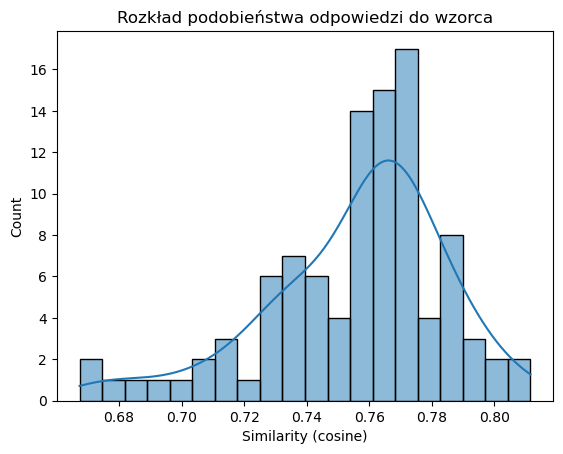

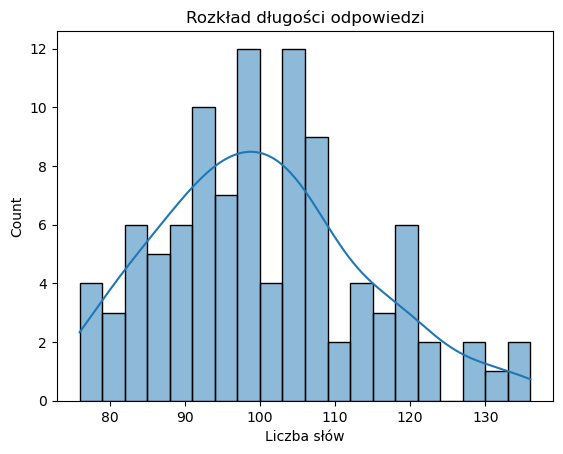

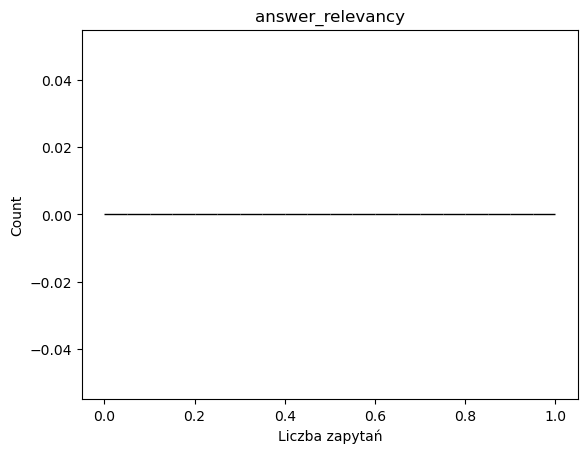

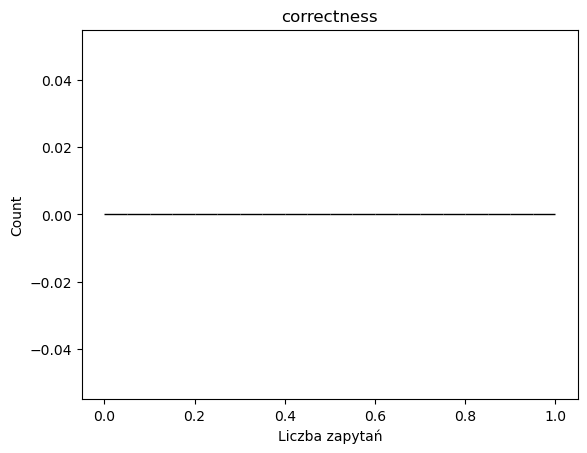

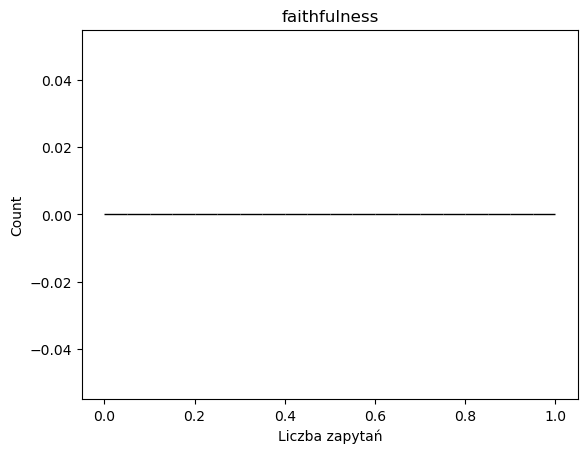

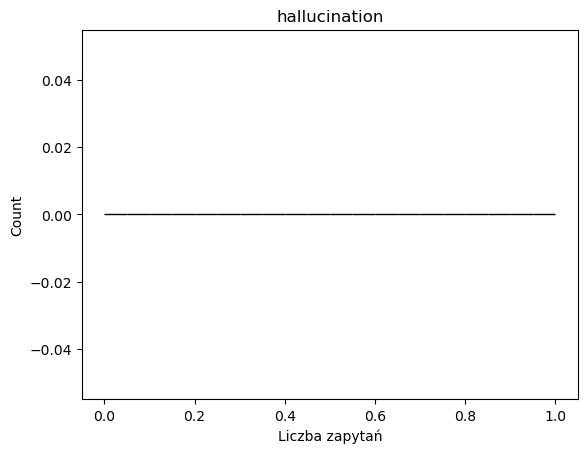

In [12]:
# --- Analiza wyników ---
print("\n📊 Statystyki:")
print(df[["similarity", "length"]].describe())

# --- Wizualizacja ---
sns.histplot(df["similarity"], bins=20, kde=True)
plt.title("Rozkład podobieństwa odpowiedzi do wzorca")
plt.xlabel("Similarity (cosine)")
plt.show()

sns.histplot(df["length"], bins=20, kde=True)
plt.title("Rozkład długości odpowiedzi")
plt.xlabel("Liczba słów")
plt.show()

sns.histplot(df["answer_relevancy"], bins=20, kde=True)
plt.title("answer_relevancy")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["correctness"], bins=20, kde=True)
plt.title("correctness")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["faithfulness"], bins=20, kde=True)
plt.title("faithfulness")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["hallucination"], bins=20, kde=True)
plt.title("hallucination")
plt.xlabel("Liczba zapytań")
plt.show()